### TO-DO
----------
Modello:
- ~~k-Cross-validation~~
- ~~ridistribuire-dati (10 sospetto 10 non-sospetto)~~
  - ~~questo devo lavorare sui dati dal di fuori con uno script python, cercare di prendere dati 50/50~~
- ~~random-under-sampler~~
- ~~serializzare il modello - pickle~~

Estensione:
- salvare anche i dati che leggo
- in modo da costruire statistiche


# 🦚 Perception
Detecting suspicious communication specificly (cyber bulling, threatning, terirosim ) from any type of txt data

**Important notes:**

- *NLTK* is a leading platform for building Python programs to work with human language data. The Natural Language Toolkit (NLTK) is an open source Python library for Natural Language Processing.

- *sklearn* is a free software machine learning library for the Python programming language, it features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.

- *Seaborn* is a Python data visualization library based on matplotlib.

- *pandas* 

- *numpy*

In [12]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt

import re, os
for dirname, _, filenames in os.walk('data/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/dataset/nytimes.csv
data/dataset/suspicious-tweets.csv
data/dataset/result.csv
data/dataset/guardian.csv


## 📜 Data

In [13]:
df = pd.read_csv('data/dataset/suspicious-tweets.csv')

df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  cant eat, drink or breath properly thanks to t...    2
1       53855  53574                            @chromachris  Clean Me!    7

In [14]:
# Count the number of characters in each message
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [15]:
# Use for pre-test only 11 number of elements!
df_labels = df['label']
df_labels.head()

0    1
1    1
2    1
3    0
4    1
Name: label, dtype: int64

### Data representation

Suspicious:  6145
Non-Suspicious:  53855


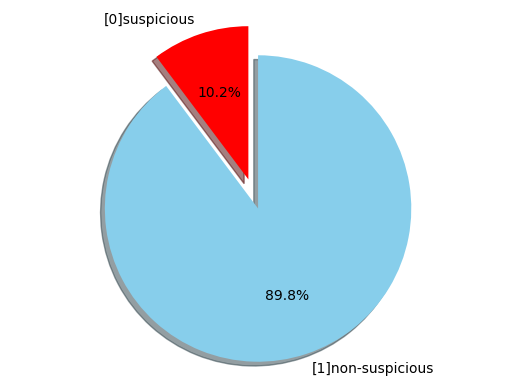

In [16]:
# Only for hinstogram
count_Class = pd.value_counts(df.label, sort = True)
print("Suspicious: ", count_Class[0])
print("Non-Suspicious: ", count_Class[1])

# Data
labels = '[0]suspicious', '[1]non-suspicious'
sizes = [count_Class[0], count_Class[1]]
colors = ['red', 'skyblue']
explode = (0.1, 0.1)


plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

### Data cleaning

**Important notes:**
- The *Porter stemming* algorithm (or 'Porter stemmer') is a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval systems.

In [17]:
# Preprocess text and clean string
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

In [18]:
# Save in message, clean text
df['message'] = df.message.apply(preprocess_text)
# Tokenization each text
df['message'] = df['message'].apply(nltk.word_tokenize)

stemmer = PorterStemmer()
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x])

In [19]:
# is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
# -> ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'blah']
show = df['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

### Data processing
**Important notes:**
- *CountVectorizer* Convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

- *TfidfTransformer* Transform a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [20]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

# Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message']);

In [21]:
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

### Data split

In [48]:
# Separe dataset in traning and test(30%)
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

## Random under sampling

Random Oversampling
- not majority = resample all classes but the majority class

Random Undersampling
- not minority = resample all classes but the minority class

0    4276
1    4276
Name: label, dtype: int64

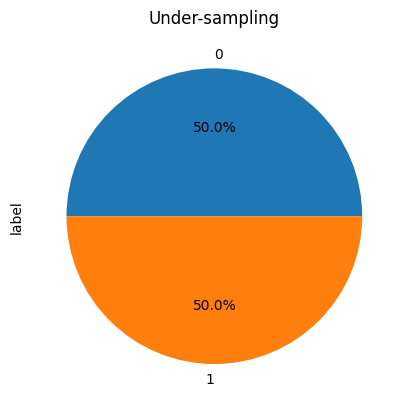

In [45]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy="not minority") # Numerical value

X_resample, y_resample = rus.fit_resample(X_train, y_train)

ax = y_resample.value_counts().plot.pie(autopct='%1.1f%%')

_ = ax.set_title("Under-sampling")

y_resample.value_counts()

## 🐱‍🏍 Learning models

### Naive bayes and evaluation

**Impotant notes:**
- Compute *confusion matrix* to evaluate the accuracy of a classification.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score

In [ ]:
# implementing naive bayes
NB = MultinomialNB().fit(X_train, y_train)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

In [ ]:
# Confronto etichette corrette dei dati di test (y) con le risposte elaborate dal programma (predicted).
error = accuracy_score(y_test, predicted)
print(f"Accuracy: {error}")

In [ ]:
report = classification_report(y_test,predicted)
print(report)

In [ ]:
# Compute confusion matrix to evaluate the accuracy of a classification
print(confusion_matrix(y_test, predicted))

### SVC
C-Support Vector Classification. The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples.

In [ ]:
# implementing SVM
sv = SVC().fit(X_train, y_train)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

In [ ]:
print(classification_report(y_test,predicted))

In [ ]:
print(confusion_matrix(y_test, predicted))

### Decision tree classifier
Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

In [ ]:
# implementing disession tree
dt = DecisionTreeClassifier().fit(X_train, y_train)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

In [ ]:
print(classification_report(y_test,predicted))

In [ ]:
print(confusion_matrix(y_test, predicted))

### An AdaBoost classifier
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

This class implements the algorithm known as AdaBoost-SAMME.

In [ ]:
# implementing adabost
ab = AdaBoostClassifier().fit(X_train, y_train)

predicted = ab.predict(X_test)
print(np.mean(predicted == y_test))

In [ ]:
print(classification_report(y_test,predicted))

In [ ]:
print(confusion_matrix(y_test, predicted))

## 📊 Finalize learning

**Important notes:**
- **Transform** documents to document-term matrix. Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor.

- **Predict** class or regression value for X. For a classification model, the predicted class for each sample in X is returned. For a regression model, the predicted value based on X is returned.

In [ ]:
# converting content to lower case
pred = (df['message'].str.lower())
# printing predictions made by model
print("prediction: {}". format(dt.predict(count_vect.transform(pred.values.astype('U')))))
# saving predictions in a variable
my_pred = dt.predict(count_vect.transform(pred.values.astype('U')))

# saving predicted labels in .csv file
df['autotag'] = my_pred
df.to_csv('data/dataset/result.csv',index = False)

## 📊 Valutate and results

In [ ]:
# getting the number of -ve , +ve  predictions 
positive = 0
negative = 0

for v in my_pred:
 if (v == 1):
  positive += 1
 elif (v == 0):
  negative += 1

In [ ]:
# function for quality measurement (can be set to required parameters)
def quality(pos,total):
    if((pos*100)/total >= 0 and (pos*100)/total <=24 ):
        print('Quality: Very Negative')
    elif((pos*100)/total >= 25 and (pos*100)/total <=49 ):
        print('Quality: Negative')
    elif((pos*100)/total >= 50 and (pos*100)/total <=74 ):
        print('Quality: Positive')
    elif((pos*100)/total >= 75 and (pos*100)/total <=100 ):
        print('Quality: Very Positive')

In [ ]:
# importing library to plot charts
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [100, 200] 
  
# heights of bars 
height = [positive,negative]
  
# labels for bars 
tick_label = ['Positive', 'Negative'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 80, color = ['green','blue']) 
  
# naming the x-axis 
plt.xlabel('Sentiment') 
# naming the y-axis 
plt.ylabel('Reviews') 
# plot title 
plt.title('Hate Speech Detection') 
  
# function to show the plot 
plt.show() 
print ("Sentiment - Positive: "+str(positive)+", Negative: "+str(negative))
quality(positive,(positive+negative))

In [ ]:
# getting negativity 
negativeity = (negative*100)/(positive+negative)
positivity = (positive*100)/(positive+negative)
print("Negativeity: "+str(negativeity)+"%")
print("Positivity: "+str(positivity)+"%")

## 💡 Random Oversampling

In [ ]:
# implementing naive bayes
NB = MultinomialNB().fit(X_resample, y_resample)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

# implementing SVM
sv = SVC().fit(X_resample, y_resample)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

# implementing disession tree
dt = DecisionTreeClassifier().fit(X_resample, y_resample)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

# implementing adabost
ab = AdaBoostClassifier().fit(X_resample, y_resample)

predicted = ab.predict(X_test)
print(np.mean(predicted == y_test))

## 💡 K-fold cross-validation

In [ ]:
# Implement K fold cross-validation
from sklearn.model_selection import cross_val_score
nb_accuracy = cross_val_score(estimator = NB, X = X_train, y = y_train, cv = 5)
print("[nb] Accuracy: {:.2f} %".format(nb_accuracy.mean()*100))
print("[nb] Standard Deviation: {:.2f} %".format(nb_accuracy.std()*100))

sv_accuracy = cross_val_score(estimator = sv, X = X_train, y = y_train, cv = 5)
print("[sv] Accuracy: {:.2f} %".format(sv_accuracy.mean()*100))
print("[sv] Standard Deviation: {:.2f} %".format(sv_accuracy.std()*100))

dt_accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 5)
print("[dt] Accuracy: {:.2f} %".format(dt_accuracies.mean()*100))
print("[dt] Standard Deviation: {:.2f} %".format(dt_accuracies.std()*100))

ab_accuracies = cross_val_score(estimator = ab, X = X_train, y = y_train, cv = 5)
print("[ab] Accuracy: {:.2f} %".format(ab_accuracies.mean()*100))
print("[ab] Standard Deviation: {:.2f} %".format(ab_accuracies.std()*100))

## 💡 Pickle model and show score

In [ ]:
# NB = MultinomialNB().fit(X_train, y_train)
# sv = SVC().fit(X_train, y_train)
# dt = DecisionTreeClassifier().fit(X_train, y_train)
# ab = AdaBoostClassifier().fit(X_train, y_train)

nb_fileModel = 'data/modelSave/nb_model.sav'
sv_fileModel = 'data/modelSave/sv_model.sav'
dt_fileModel = 'data/modelSave/dt_model.sav'
ab_fileModel = 'data/modelSave/ab_model.sav'

pickle.dump(NB, open(nb_fileModel, 'wb'))
pickle.dump(sv, open(sv_fileModel, 'wb'))
pickle.dump(dt, open(dt_fileModel, 'wb'))
pickle.dump(ab, open(ab_fileModel, 'wb'))


In [ ]:
nb_loaded_model = pickle.load(open(nb_fileModel, 'rb'))
sv_loaded_model = pickle.load(open(sv_fileModel, 'rb'))
dt_loaded_model = pickle.load(open(dt_fileModel, 'rb'))
ab_loaded_model = pickle.load(open(ab_fileModel, 'rb'))

# Predicting the Test set results
nb_pred = nb_loaded_model.predict(X_test)
print("MultinomialNB: ", nb_loaded_model.score(X_test, y_test))

sv_pred = sv_loaded_model.predict(X_test)
print("SVC: ", sv_loaded_model.score(X_test, y_test))

dt_pred = dt_loaded_model.predict(X_test)
print("DecisionTreeClassifier: ", dt_loaded_model.score(X_test, y_test))

ab_pred = ab_loaded_model.predict(X_test)
print("AdaBoostClassifier: ", ab_loaded_model.score(X_test, y_test))